In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Parameters (from the paper's simulation)
params = {
    "S0": 100,        # Initial mid-price
    "T": 1,           # Time horizon (e.g., 1 day)
    "sigma": 2,       # Volatility
    "gamma": 0.1,     # Risk aversion
    "k": 1.5,         # Order book depth parameter
    "A": 140,         # Order arrival rate scaling
    "dt": 0.005,      # Time step
    "q0": 0,          # Initial inventory
    "num_sims": 1000  # Number of simulations
}

In [3]:
def simulate_mid_price(params):
    """Simulate mid-price using Brownian motion."""
    n_steps = int(params["T"] / params["dt"])
    dW = np.random.normal(0, np.sqrt(params["dt"]), n_steps)
    S = params["S0"] + params["sigma"] * np.cumsum(dW)
    return S

def compute_reservation_price(S_t, q, t, params):
    """Reservation price: r = S_t - q * gamma * sigma^2 * (T - t)."""
    T_minus_t = params["T"] - t
    return S_t - q * params["gamma"] * (params["sigma"] ** 2) * T_minus_t

def compute_optimal_spreads(params, t):
    """Optimal bid/ask spreads (simplified closed-form)."""
    spread = params["gamma"] * (params["sigma"] ** 2) * (params["T"] - t) + (2 / params["gamma"]) * np.log(1 + params["gamma"] / params["k"])
    return spread # Symmetric around reservation price
def compute_order_arrival_intensities(params, spread_bid, spread_ask):
    lambda_bid = params["A"] * np.exp(-params["k"] * spread_bid)
    lambda_ask = params["A"] * np.exp(-params["k"] * spread_ask)
    return lambda_bid, lambda_ask
def run_simulation(params):
    """Run one simulation of the inventory-based strategy."""
    n_steps = int(params["T"] / params["dt"])
    S = simulate_mid_price(params)
    cash = 0
    inventory = params["q0"]
    wealth = np.zeros(n_steps)
    q_hist = np.zeros(n_steps)

    # Initialize tracking arrays
    bid_prices = np.zeros(n_steps)
    ask_prices = np.zeros(n_steps)
    reservation_prices = np.zeros(n_steps)
    inventory_values = np.zeros(n_steps)
    mid_prices = S.copy()

    for i in range(n_steps):
        t = i * params["dt"]
        r = compute_reservation_price(S[i], inventory, t, params)
        spread = compute_optimal_spreads(params, t)
        
        #bid and ask Quote
        p_bid = r - spread  # Reservation bid price
        p_ask = r + spread  # Reservation ask price

        # Record prices
        bid_prices[i] = p_bid
        ask_prices[i] = p_ask
        reservation_prices[i] = r

        spread_bid = S[i] - p_bid
        spread_ask = p_ask - S[i]
        
        # Simulate order arrivals (Poisson processes)
        lambda_bid, lambda_ask = compute_order_arrival_intensities(params, spread_bid, spread_ask)

        # Check if bid/ask orders are executed
        if np.random.rand() < lambda_bid * params["dt"]:
            cash -= p_bid
            inventory += 1
        if np.random.rand() < lambda_ask * params["dt"]:
            cash += p_ask
            inventory -= 1

        # Update wealth (X + qS)
        wealth[i] = cash + inventory * S[i]
        q_hist[i] = inventory
        inventory_values[i] = inventory

    # return wealth, q_hist
    return {
        "wealth": wealth,
        "q_hist": q_hist,
        "bid": bid_prices,
        "ask": ask_prices,
        "reservation": reservation_prices,
        "mid": mid_prices,
        "inventory_values": inventory_values
    }

In [8]:
# Run multiple simulations
results = [run_simulation(params) for _ in range(params["num_sims"])]
list_of_wealth_and_inventory_values = [[res['wealth'], res['q_hist']] for res in results]
profits = [res[0][-1] for res in list_of_wealth_and_inventory_values]  # Terminal wealth

Mean P&L: 44.79
Std P&L: 8.16


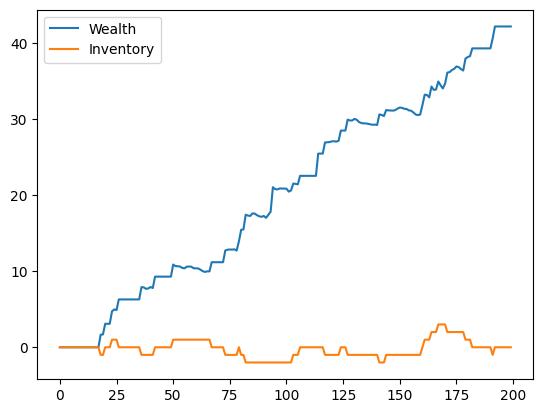

In [9]:
# Analyze results
print(f"Mean P&L: {np.mean(profits):.2f}")
print(f"Std P&L: {np.std(profits):.2f}")

# Plot sample simulation
plt.plot(list_of_wealth_and_inventory_values[0][0], label='Wealth')
plt.plot(list_of_wealth_and_inventory_values[0][1], label='Inventory')
plt.legend()
plt.show()


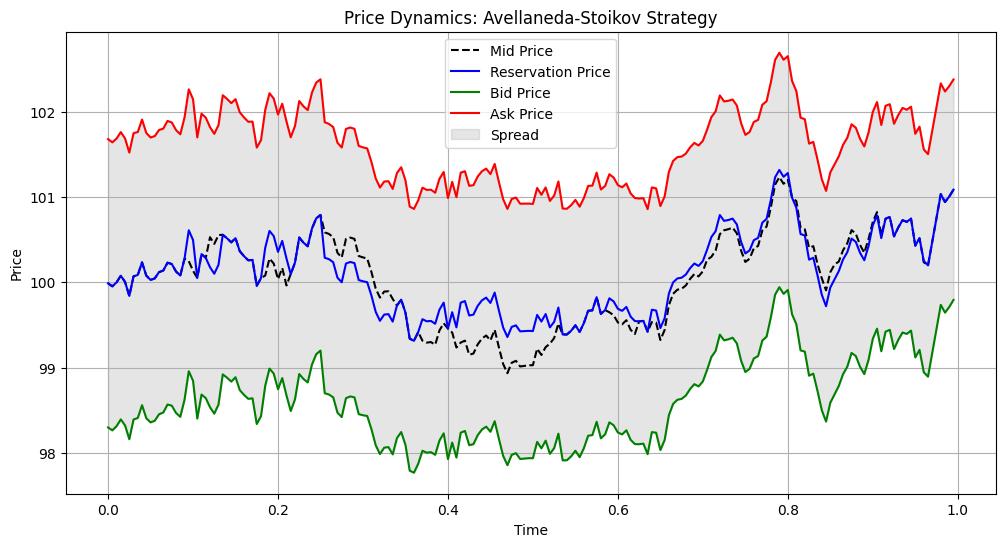

In [10]:
#plotting one of instance for bid, ask, mid and reservation
result = results[0]
time = np.arange(0, params["T"], params["dt"])
plt.figure(figsize=(12, 6))
plt.plot(time, result["mid"], label='Mid Price', color='black', linestyle='--')
plt.plot(time, result["reservation"], label='Reservation Price', color='blue')
plt.plot(time, result["bid"], label='Bid Price', color='green')
plt.plot(time, result["ask"], label='Ask Price', color='red')

plt.fill_between(time, result["bid"], result["ask"], 
                 color='gray', alpha=0.2, label='Spread')

plt.title("Price Dynamics: Avellaneda-Stoikov Strategy")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


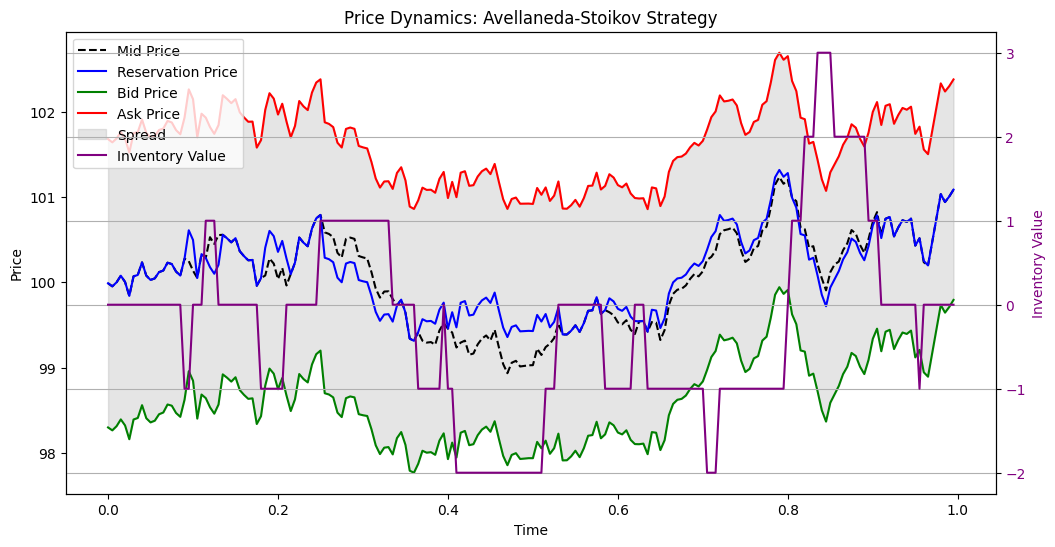

In [11]:
#plotting one of instance for bid, ask, mid and reservation, adding inventory at right vertical axis
result = results[0]
time = np.arange(0, params["T"], params["dt"])

fig, ax1 = plt.subplots(figsize=(12, 6)) # Create the primary axes

# Plot Prices on the primary y-axis (ax1)
ax1.plot(time, result["mid"], label='Mid Price', color='black', linestyle='--')
ax1.plot(time, result["reservation"], label='Reservation Price', color='blue')
ax1.plot(time, result["bid"], label='Bid Price', color='green')
ax1.plot(time, result["ask"], label='Ask Price', color='red')
# Use ax1 for fill_between
ax1.fill_between(time, result["bid"], result["ask"],
                 color='gray', alpha=0.2, label='Spread')


ax1.set_xlabel("Time")
ax1.set_ylabel("Price", color='black') # Label for the primary y-axis
ax1.tick_params(axis='y', labelcolor='black') # Set tick color

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot Inventory Value on the secondary y-axis (ax2)
ax2.plot(time, result["inventory_values"], label='Inventory Value', color='purple') # Changed color for clarity

ax2.set_ylabel("Inventory Value", color='purple') # Label for the secondary y-axis
ax2.tick_params(axis='y', labelcolor='purple') # Set tick color
# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.title("Price Dynamics: Avellaneda-Stoikov Strategy")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
plt.grid(True)
plt.show()
